In [1]:
import numpy as np
import pandas as pd

In [2]:
threshold = 3
cutoff = 8

## Build the Transition Matrix of Probabilities is given
### - on rows we have current state
### - on columns we have new state

In [3]:
edges = pd.read_csv(f'edges.20211117_v3.csv',
                    low_memory=False, 
                    encoding='utf-8',
                    float_precision='round_trip')

In [4]:
edges.shape

(10015, 9)

In [5]:
edges.head()

HRTB Id Event Effective Date  seq_id  \
0      423           2007-07-10     1.0   
1      423           2008-06-02     2.0   
2      423           2008-12-19     3.0   
3      423           2011-02-08     4.0   
4      464           2010-09-27     1.0   

                                    position_from                position_to  \
0                       game designer(artistique)              game designer   
1                                   game designer          camera specialist   
2                               camera specialist              game designer   
3                                   game designer             audio designer   
4  network administrator(services professionnels)  senior applications admin   

   upd      position_from_upd            position_to_upd  transition_days  
0    1          game designer              game designer                0  
1    0          game designer          camera specialist                0  
2    0      camera specialist              game designer                0  
3    0          game designer             audio designer                0  
4    1  network administrator  senior applications admin                0

In [6]:
edges = edges[edges['position_from_upd'] != edges['position_to_upd']]

## Replace space with "_"

In [7]:
edges['position_from_upd'] = edges['position_from_upd'].str.replace(" ", "_")
edges['position_to_upd'] = edges['position_to_upd'].str.replace(" ", "_")

In [8]:
len(edges['position_to'].unique()), len(edges['position_to_upd'].unique())

(1191, 1101)

In [9]:
edges_agg = edges.groupby(['position_from_upd','position_to_upd'])['HRTB Id'].count()

In [10]:
edges_agg.shape

(3589,)

In [11]:
edges_agg = edges_agg[edges_agg >= threshold]

In [12]:
edges_agg.sort_values(ascending = False).head(10)

position_from_upd      position_to_upd           
tester                 development_tester            160
generalist_programmer  game_play_programmer          105
                       programming_team_lead         100
modeler                level_artist                   88
programming_team_lead  project_lead_-_programming     80
level_artist           graphic_design_team_lead       74
generalist_programmer  online_programmer              74
                       technical_lead                 66
3d_animator            gameplay_animator              65
game_play_programmer   programming_team_lead          59
Name: HRTB Id, dtype: int64

In [13]:
edges_agg.loc[('level_designer','level_design_team_lead')]

51

In [14]:
edges_agg.loc[('level_designer','team_lead')]

3

In [15]:
edges_agg.loc[('level_designer',)]

position_to_upd
assistant_director_-_level_design        33
assistant_technical_director_-_design    18
camera_specialist                         7
cinematic_designer                        4
development_tester                        3
director_-_level_design                  14
event_scripter                           17
game_designer                            25
integrator                                8
level_design_team_lead                   51
scriptwriter                              3
team_lead                                 3
technical_designer                       25
technical_director_-_design              16
Name: HRTB Id, dtype: int64

## Average number of positions per employee

In [16]:
edges.groupby('HRTB Id')['position_from_upd'].nunique().mean()

1.9330316742081448

<AxesSubplot:>

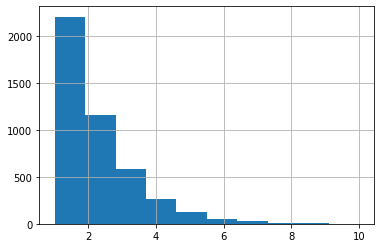

In [17]:
edges.groupby('HRTB Id')['position_from_upd'].nunique().hist()

## Create states

In [18]:
allstates = set(edges_agg.index.get_level_values(0)).union(set(edges_agg.index.get_level_values(1)))
n = len(allstates)
print("n=",n)
states = list(allstates)

n= 287


## Create transition probability matrix

In [19]:
edges_agg.loc[('character_modeler', 'graphic_design_team_lead')]

20

In [20]:
# init with 0
tpm = [[0 for i in range(n)] for j in range(n)]
# populate with nij = number of transition from i to j
for i,source in enumerate(allstates):
    if i % 100 == 0:
        print(i, source)
    for j,dest in enumerate(allstates):
        if i != j:
            try:
                hrcnt = edges_agg.loc[(source, dest)]
                tpm[i][j] = hrcnt
            except:
                pass;
        else:
            tpm[i][j] = 0

0 security_analyst
100 business_analyst
200 brand_director


In [21]:
p = [[0 for i in range(n)] for j in range(n)]
for i in range(n):
    i_sum = 0
    for j in range(n):
        i_sum = i_sum + tpm[i][j]
    if i_sum > 0:
        for j in range(n):
            p[i][j] = tpm[i][j]/i_sum
    else:
        p[i][i] = 1

In [22]:
for i in range(n):
    if round(sum(p[i])) != 1:
        print(i, sum(p[i]), "Somewhere, something went wrong. Transition matrix, perhaps?")

In [23]:
len(p), len(p[0])

(287, 287)

In [24]:
# p[:10]

## Remove rows and cols with 0

In [25]:
pa = np.array(p)
dim = len(pa[0])
pa.shape, dim

((287, 287), 287)

In [26]:
len(pa[1,:]), len(pa[:,1])

(287, 287)

In [27]:
for i in range(len(p)):
    if sum(pa[i,:]) == 0:
        if sum(pa[:,i]) == 0:
            print(i)

## Build the graph with:
### 1 - vertex = states
### 2- edges weight = -log(p(i,j)

In [28]:
import networkx as nx  # For the magic
import pydot
import matplotlib.pyplot as plt  # For plotting

In [29]:
p_arr = np.array(p)
p_arr.shape

(287, 287)

## Transition probability matrux: replace zeros with min

In [30]:
def replaceZeroes(data):
    min_nonzero = np.min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data

p_arr = replaceZeroes(p_arr)
np.min(p_arr)

0.004918032786885246

In [31]:
G = nx.DiGraph()

for i, origin_state in enumerate(states):
    for j, destination_state in enumerate(states):
        if i!=j:
            cost = -np.log(p_arr[i][j])
            if cost < 0:
                print(origin_state, destination_state, p[i][j])                
            if p[i][j] > 0:          
                G.add_edge(origin_state,
                           destination_state,
                           weight = cost,
                           prob = p[i][j],
                           hrcnt = tpm[i][j]
                          )

In [32]:
len(G.nodes())

287

In [33]:
len(G.edges())

607

In [34]:
G.get_edge_data("3d_animator", "gameplay_animator")

{'weight': 1.0296194171811581, 'prob': 0.35714285714285715, 'hrcnt': 65}

In [35]:
# test
rate = -np.log(G.get_edge_data("3d_animator", "gameplay_animator")['prob'])
print(G.get_edge_data("3d_animator", "gameplay_animator")['prob'], rate)

0.35714285714285715 1.0296194171811581


In [36]:
prob = [(e[2]['prob']) for e in G.edges(data=True)]

## Draw subgraph

In [37]:
def show_graph(g, source, target):
    dot_graph = nx.nx_pydot.to_pydot(g)
    shortest_path = nx.shortest_path(g, source=source, target=target, weight='weight', method='dijkstra')
#     shortest_path2 = nx.bellman_ford_predecessor_and_distance(g, source=source, target=target, weight='weight')
#     print(shortest_path)
#     print(shortest_path2)
    
    for node in dot_graph.get_nodes():
        lbl_node = node.get_name().replace('\"','')
        node.set_style('"rounded,filled", fixedsize="true", width="2", color="#ABD5E3",fontcolor="black",fontsize="10"')

        if lbl_node in shortest_path:
            node.set_style('"rounded,filled",fixedsize="true", width="2", color="#F63366",fontcolor="white",fontsize="10"')

    total_weight = sum([x[2]['hrcnt'] for x in g.edges(data=True)])

    for edge in dot_graph.get_edges():
        # print(edge)
        w = edge.get_attributes()['weight']
        p = edge.get_attributes()['prob']
        hrc = edge.get_attributes()['hrcnt']
        
        source = edge.get_source().replace('\"','')
        destination = edge.get_destination().replace('\"','')
        
        edge.set_penwidth(0.2 + 50 * int(hrc)/total_weight)
        if source in shortest_path and \
            destination in shortest_path and \
            abs(shortest_path.index(source)-shortest_path.index(destination)) == 1:
            edge.set_color('#F63366')
        else:
            edge.set_color('grey')

        edge.set_tooltip(edge.get_source() + ' -> '
                         + edge.get_destination() + '\n'
                         + 'cost to minimize: ' + str(w) + ', prob: ' + str(p) + ', hrcnt=' + str(hrc))

    dot_graph.set_graph_defaults(
#         size="\"25,25\"",
        # height=10,
        ratio='auto',
        # fontname='Courier',
        fontsize='12',
        compound=True,
        splines='curve',
        layout='dot',
        bgcolor='#0E1117',
    )

    return dot_graph, shortest_path

In [38]:
from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

In [39]:
def viz_paths(G, state_from, state_to, filename):
    paths = list(nx.all_simple_paths(G, state_from, state_to, cutoff=cutoff))
    sg = nx.DiGraph()
    for r in paths:
#         route_edges = [(r[n], r[n + 1], edges_agg.loc[(r[n], r[n + 1])]) for n in range(len(r) - 1)]
        route_edges = [(r[n], r[n + 1], G.get_edge_data(r[n], r[n + 1])['weight']) for n in range(len(r) - 1)]
        sg.add_weighted_edges_from(route_edges)
        
    for node1, node2, data in sg.edges.data():
        data['prob'] = G.get_edge_data(node1, node2)['prob']
        data['hrcnt'] = G.get_edge_data(node1, node2)['hrcnt']
    
    graph, shortest = show_graph(sg, state_from, state_to)
    view_pydot(graph)
    graph.write_svg(filename + '.svg')
    print('Optimal path', shortest)

## Calculate the shortest (ie. most probable path) between two states

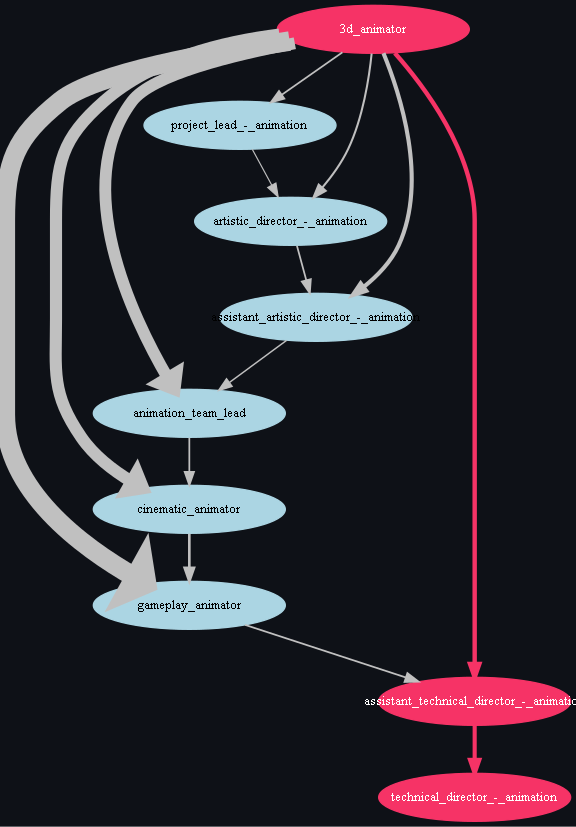

Optimal path ['3d_animator', 'assistant_technical_director_-_animation', 'technical_director_-_animation']


14

In [40]:
state_from = '3d_animator'
state_to = 'technical_director_-_animation'
viz_paths(G, state_from, state_to, '11')
edges_agg.loc[('3d_animator','assistant_technical_director_-_animation')]

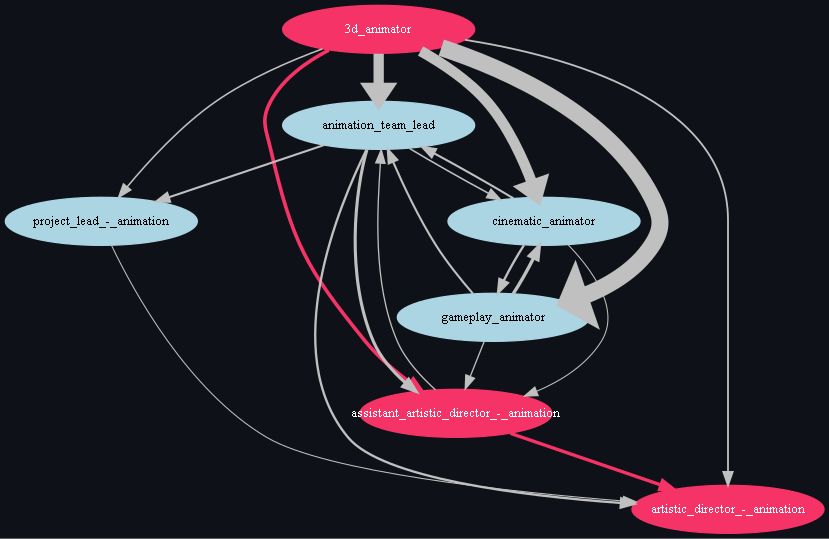

Optimal path ['3d_animator', 'assistant_artistic_director_-_animation', 'artistic_director_-_animation']


6

In [41]:
state_from = '3d_animator'
state_to = 'artistic_director_-_animation'
viz_paths(G, state_from, state_to, '22')
edges_agg.loc[(state_from, state_to)]

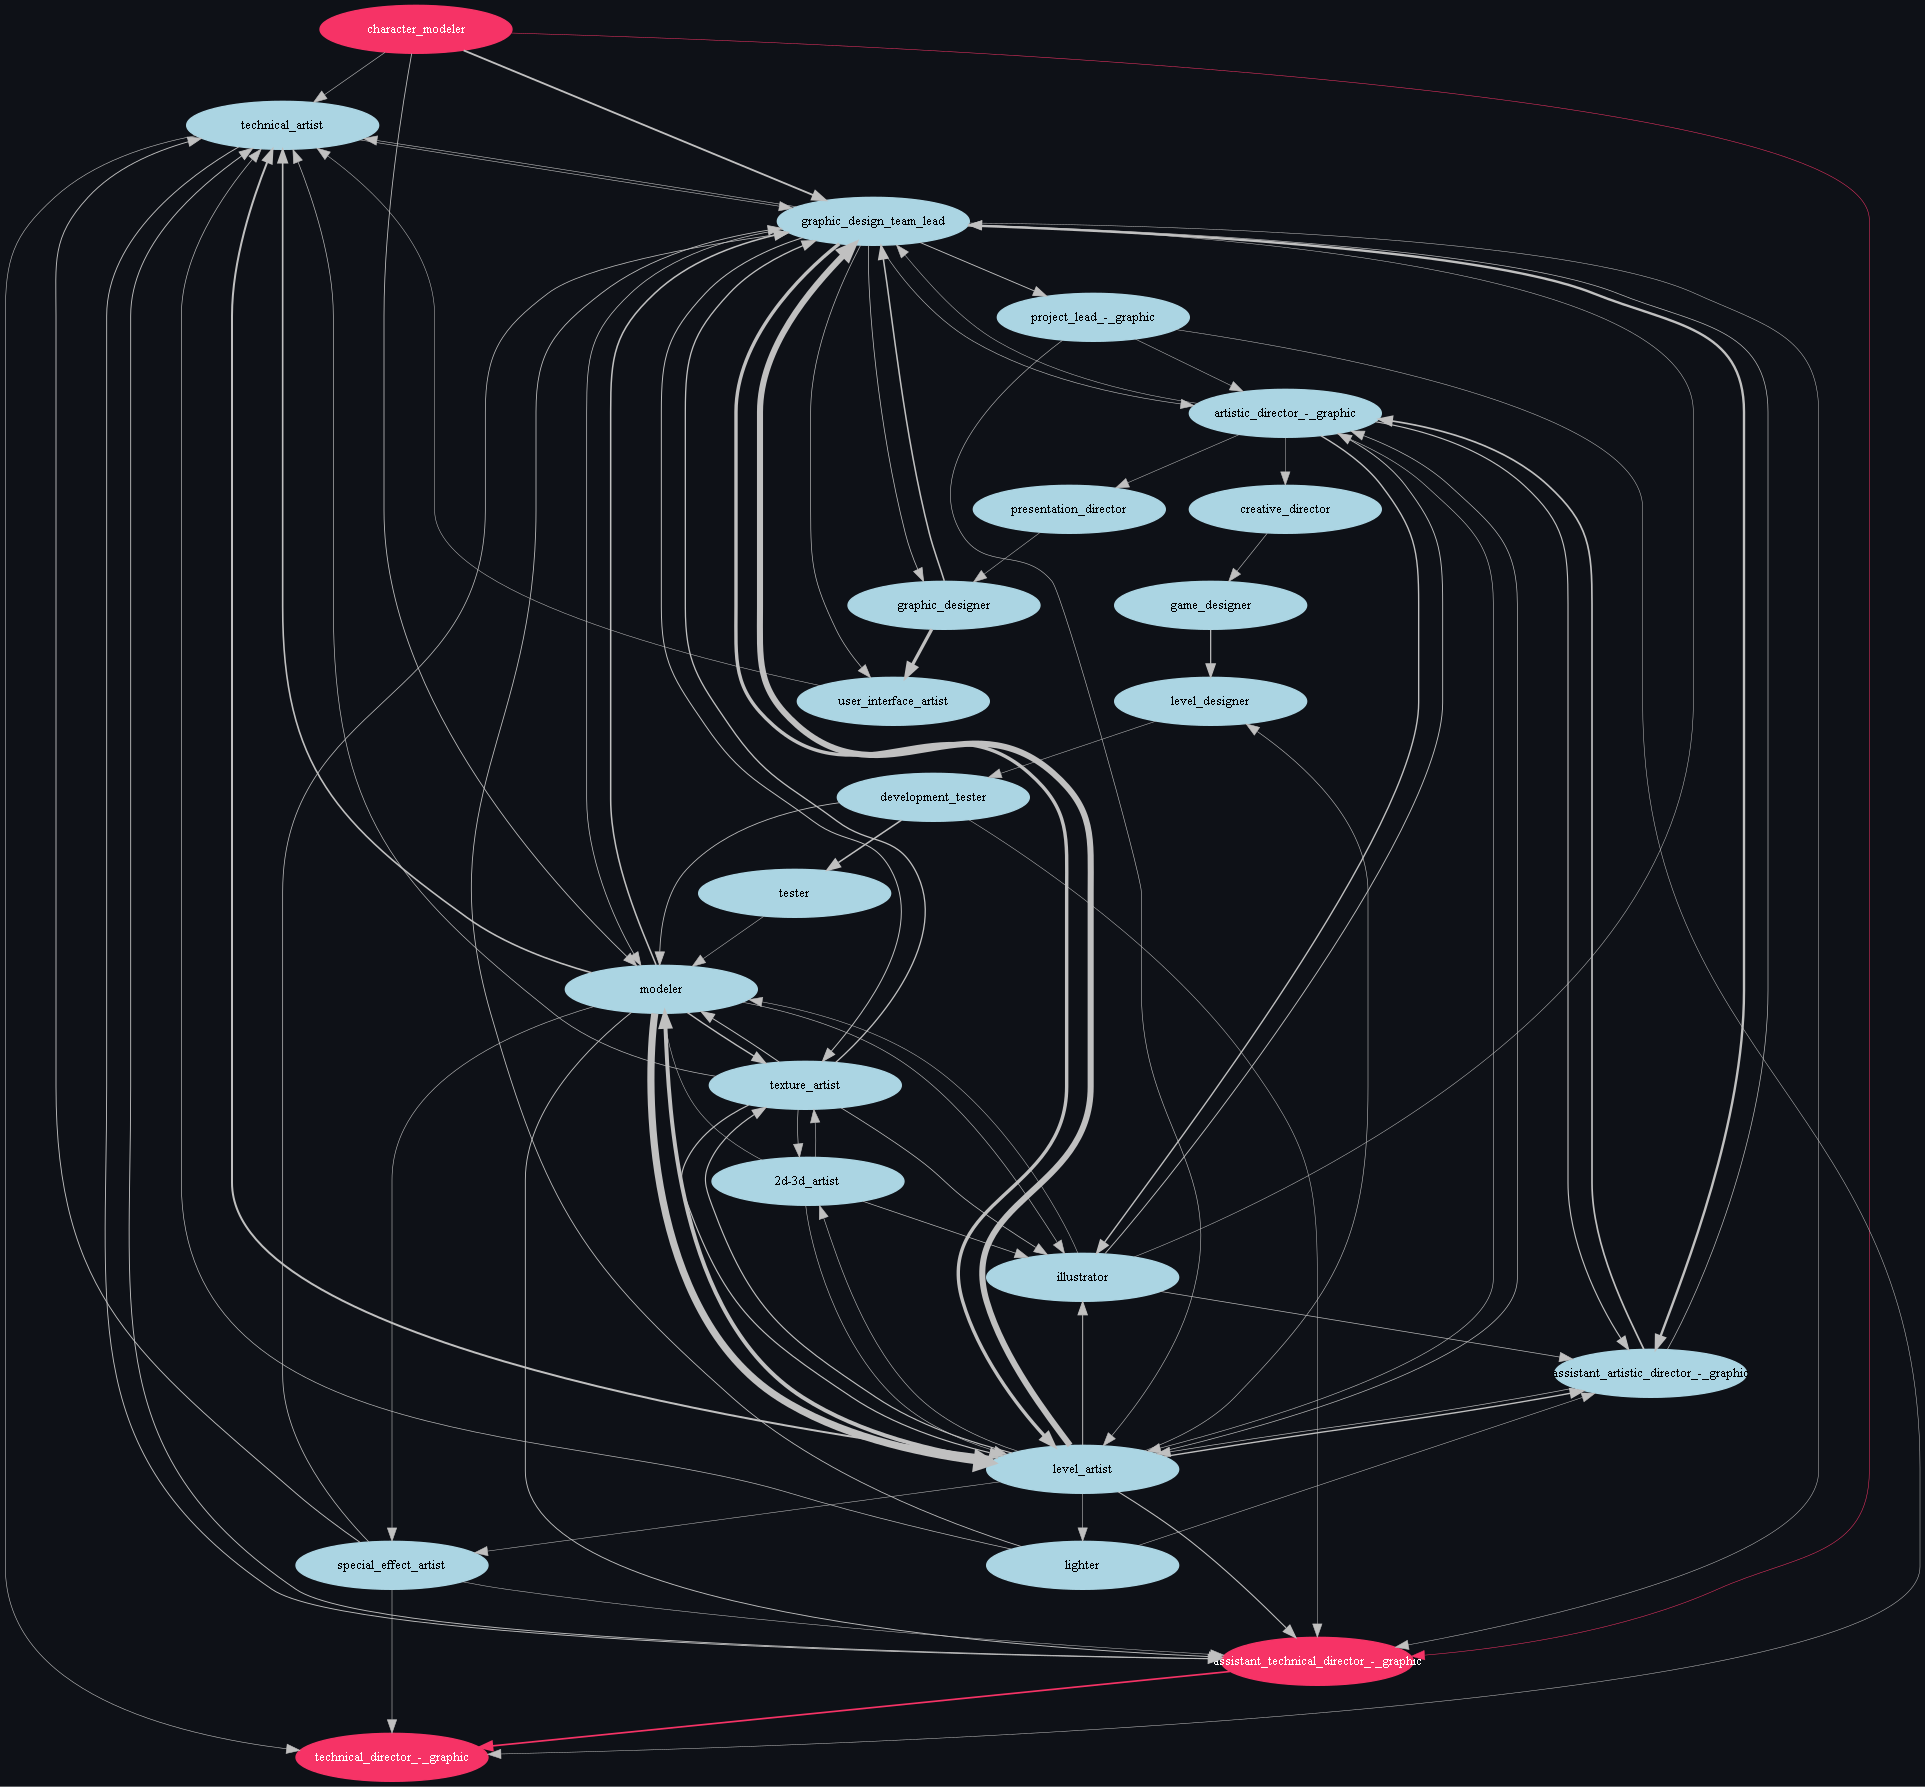

Optimal path ['character_modeler', 'assistant_technical_director_-_graphic', 'technical_director_-_graphic']


In [42]:
state_from = 'character_modeler'
state_to = 'technical_director_-_graphic'
viz_paths(G, state_from, state_to, '33')

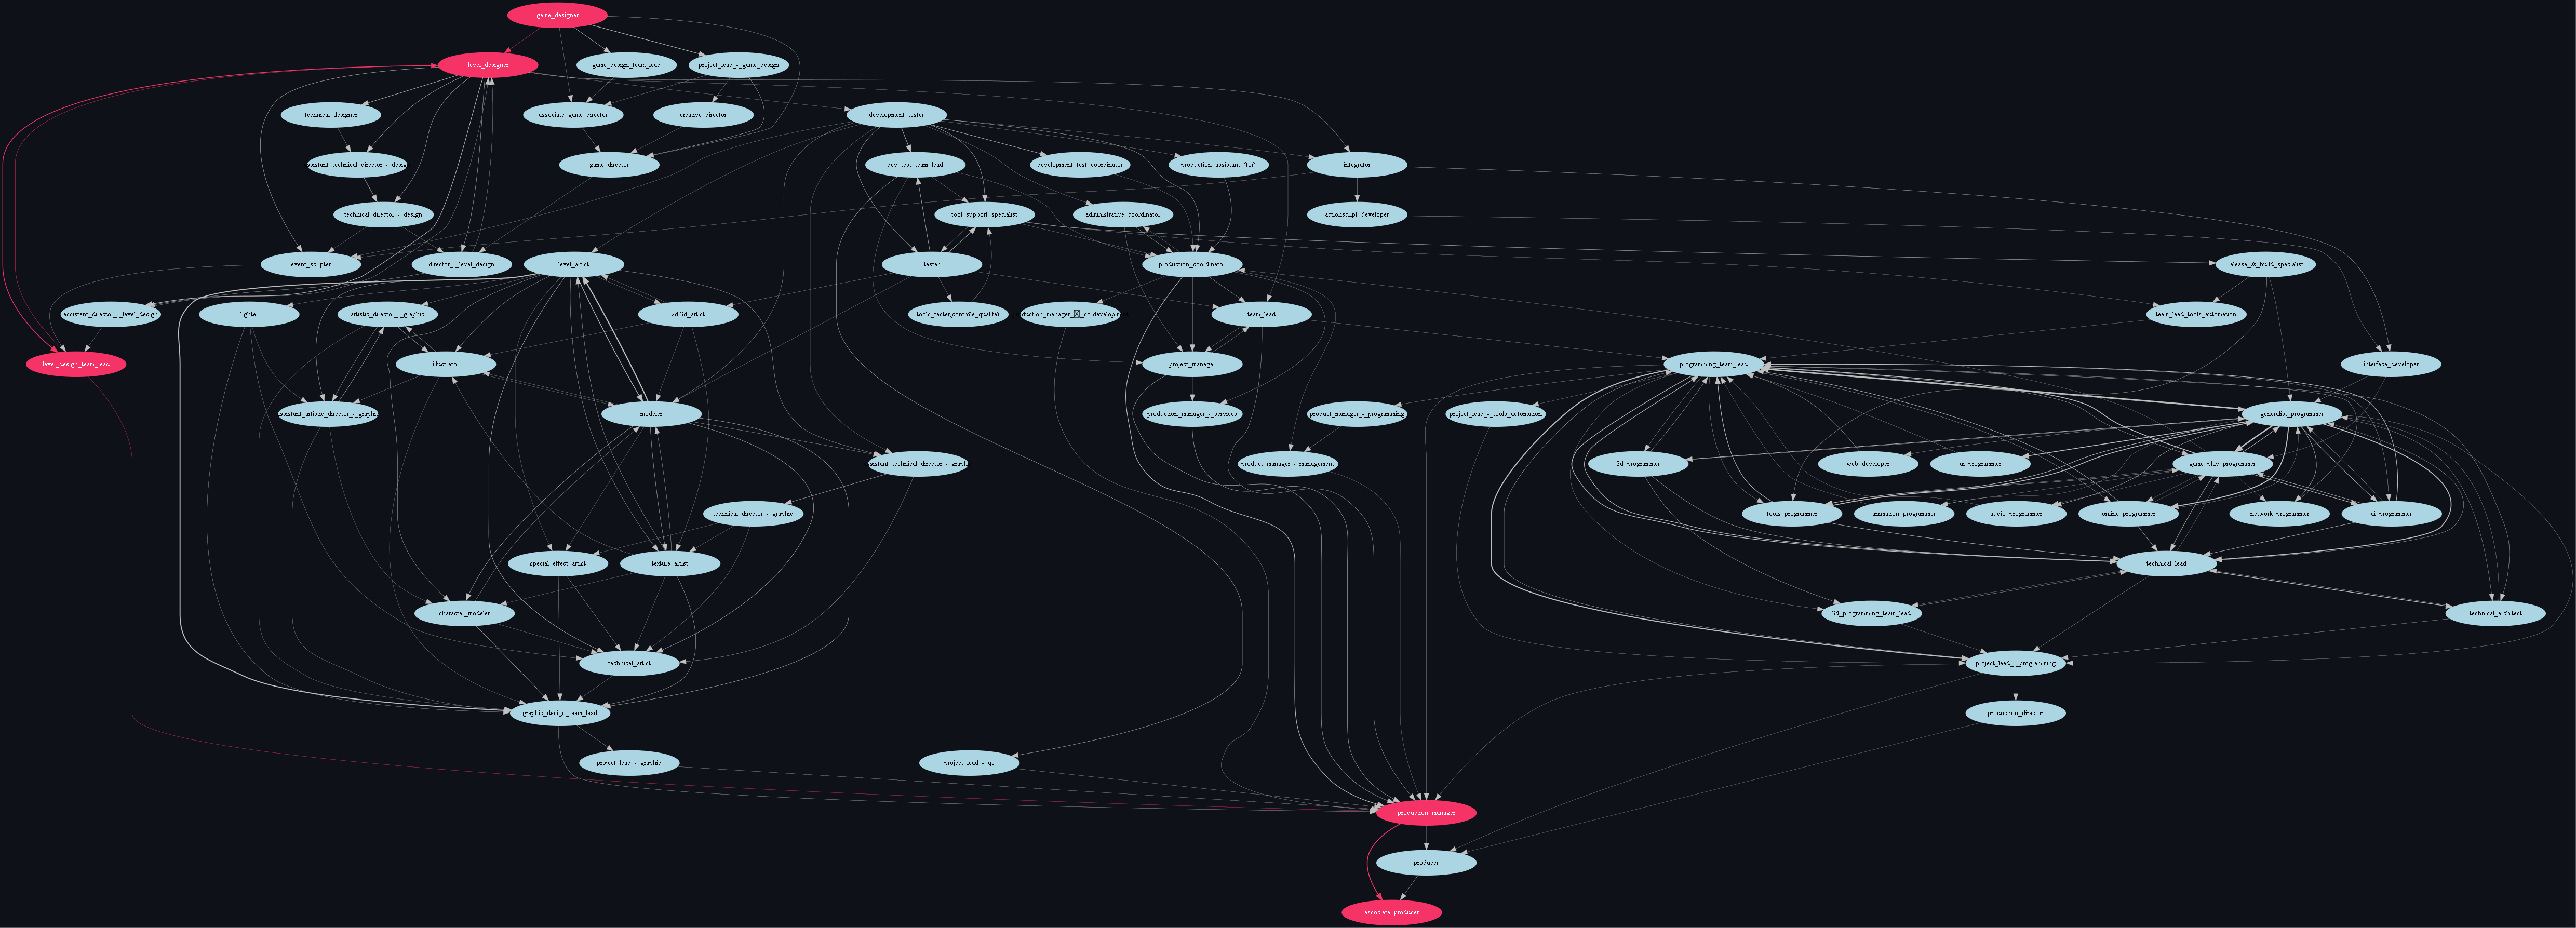

Optimal path ['game_designer', 'level_designer', 'level_design_team_lead', 'production_manager', 'associate_producer']


In [43]:
state_from = 'game_designer'
state_to = 'associate_producer'
viz_paths(G, state_from, state_to, '44')

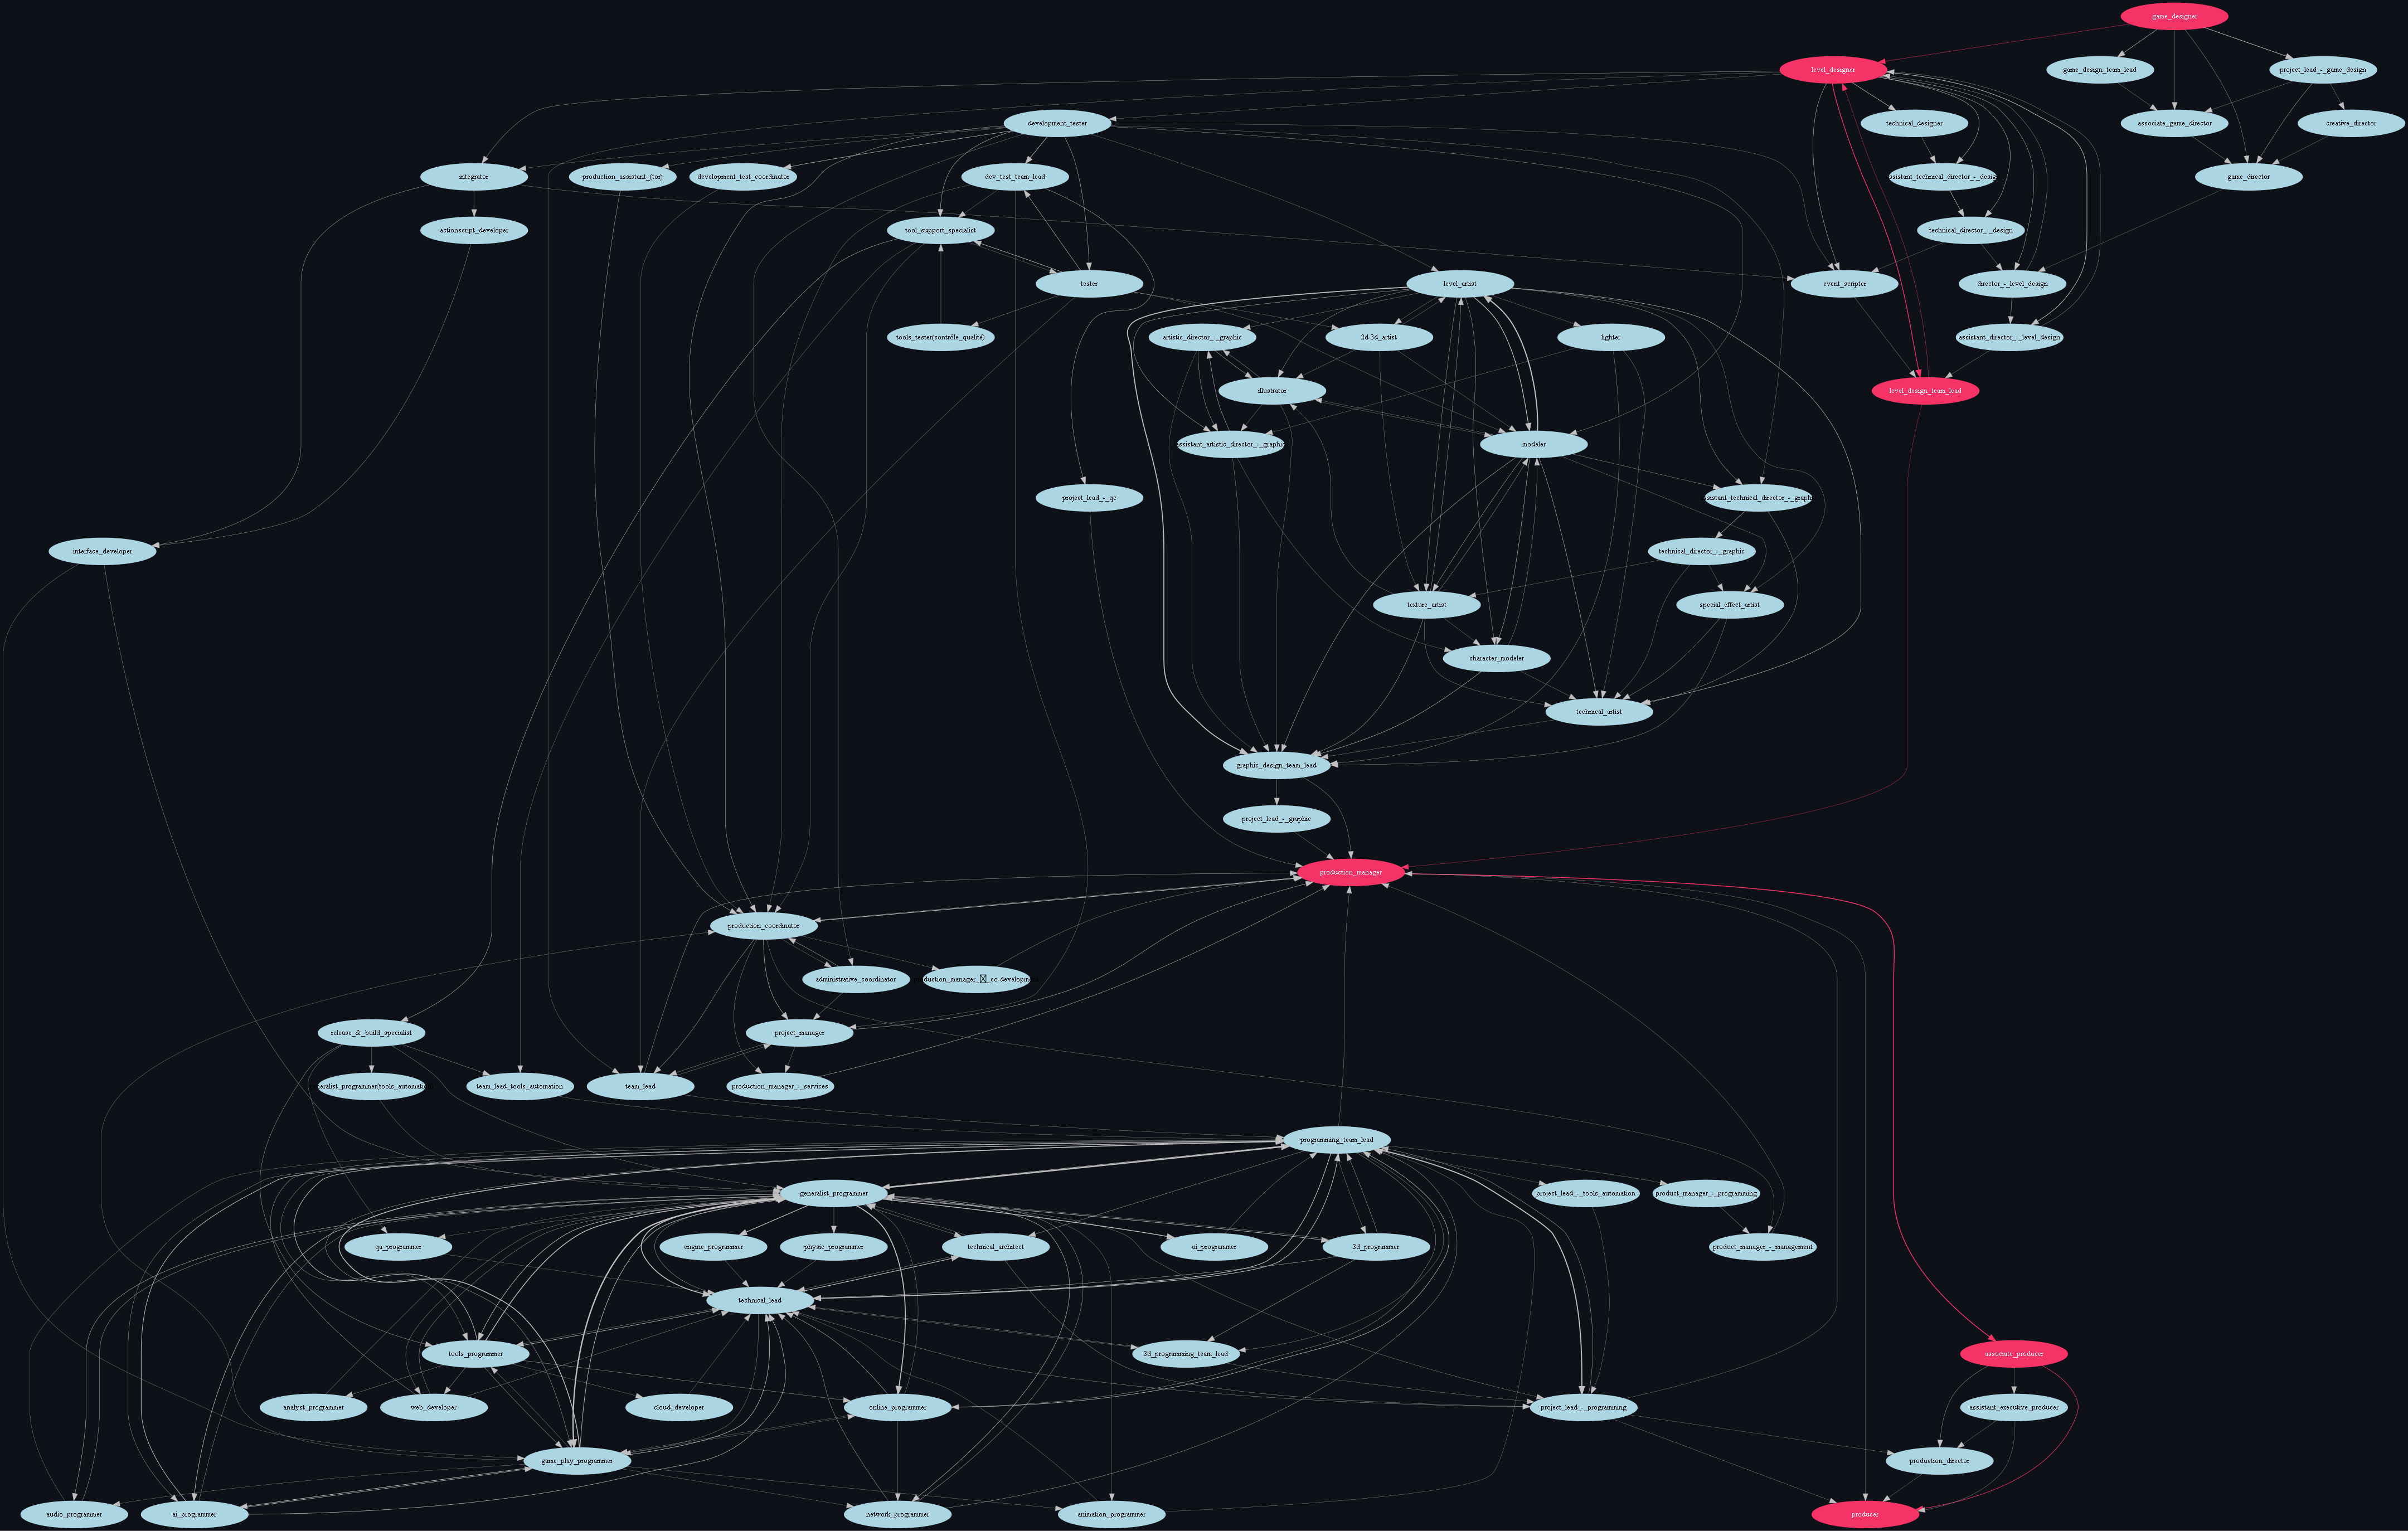

Optimal path ['game_designer', 'level_designer', 'level_design_team_lead', 'production_manager', 'associate_producer', 'producer']


In [44]:
state_from = 'game_designer'
state_to = 'producer'
viz_paths(G, state_from, state_to, '77')

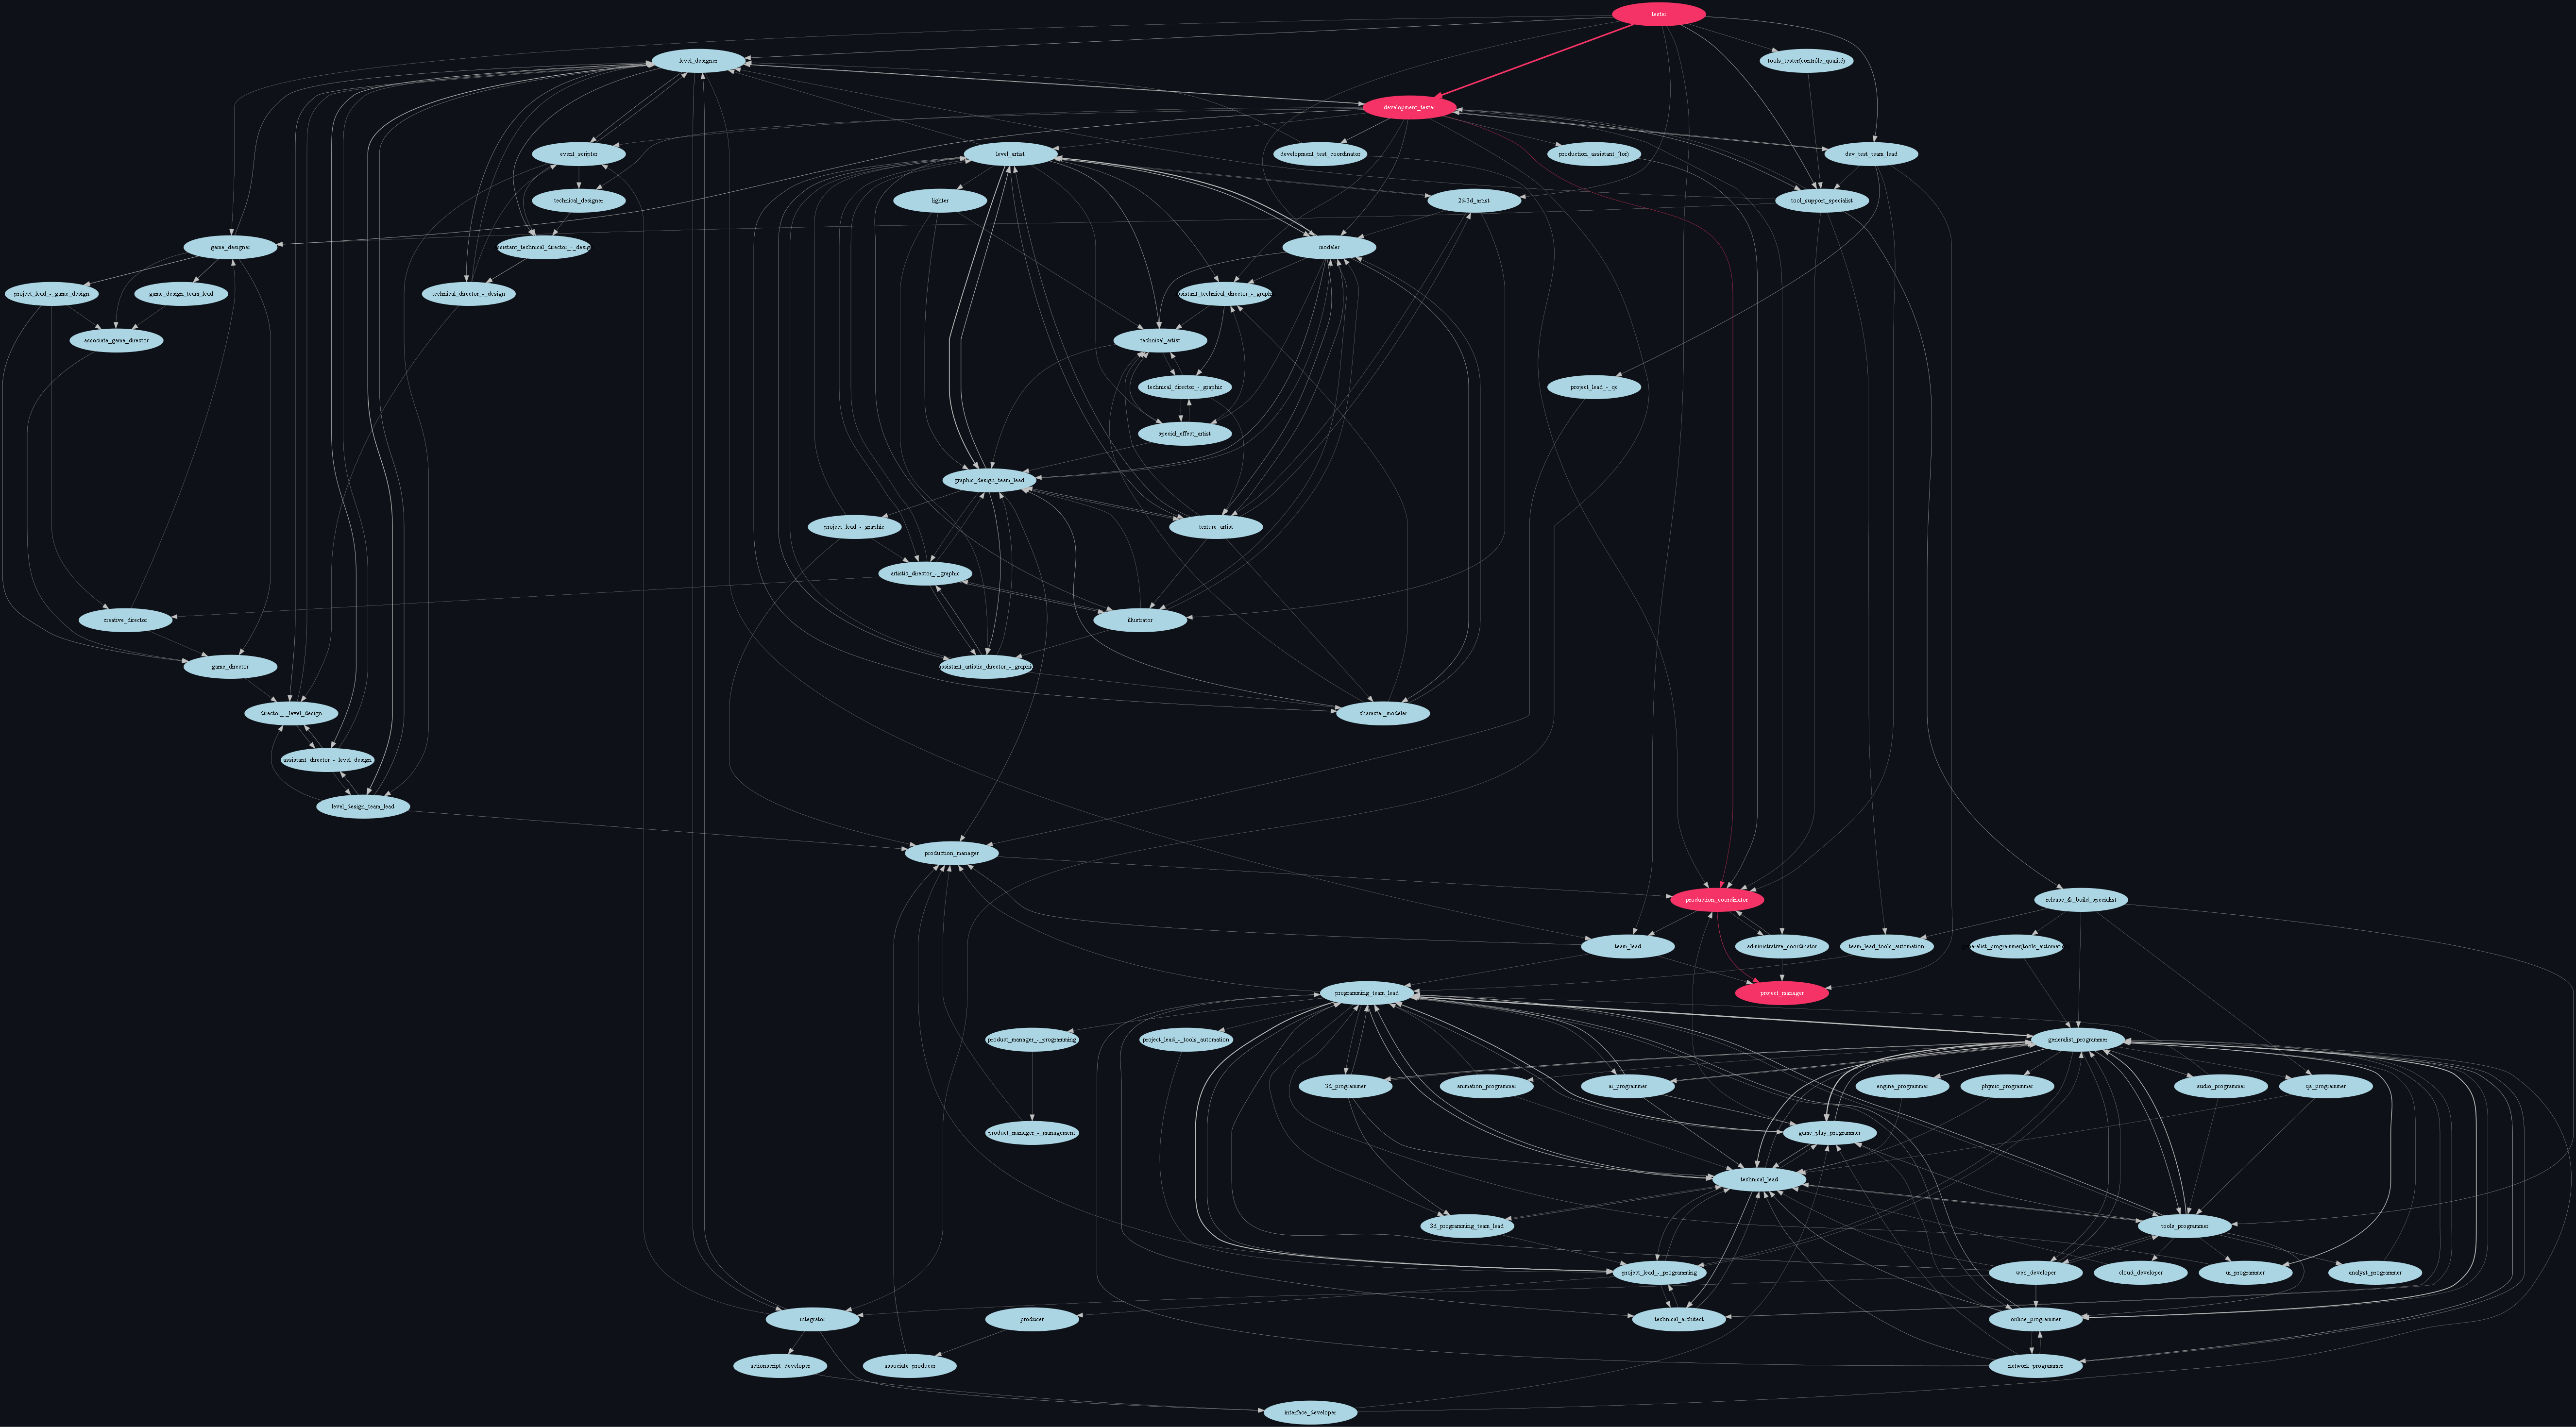

Optimal path ['tester', 'development_tester', 'production_coordinator', 'project_manager']


In [45]:
state_from = 'tester'
state_to = 'project_manager'
viz_paths(G, state_from, state_to, '55')